In [1]:
import torch
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss, kurtosis_loss, kurtosis2_loss
from dstft import DSTFT, FDSTFT
from dstft import frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
signal, sr = librosa.load('../../../data/raw/fan/7.wav', sr=2_000)
vitesse = {}
Audio(signal, rate=sr)

In [11]:
x = torch.from_numpy(signal).float().to(device)[None, :70_000]#, 22_000:52_000] 
print(sr, x.shape)

2000 torch.Size([1, 70000])


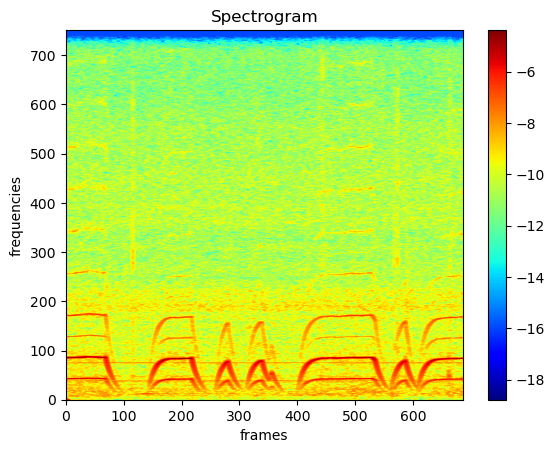

In [12]:
dstft = FDSTFT(x, win_length=1_500, support=1_500, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
vitesse['1500'] = spec.cpu() 
dstft.print(spec, weights=False, wins=False, bar=True)

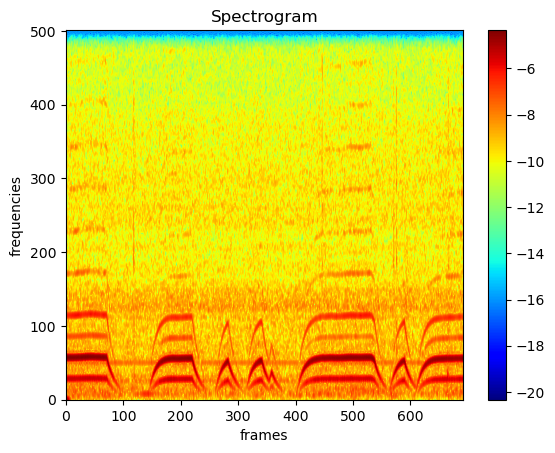

In [13]:
dstft = FDSTFT(x, win_length=300, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
vitesse['300'] = spec.cpu() 
dstft.print(spec, weights=False, wins=False, bar=True)

In [ ]:
dstft = FDSTFT(x, win_length=500, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
vitesse['500'] = spec.cpu() 
dstft.print(spec, weights=False, wins=False, bar=True)

Single window length

In [ ]:
print(dstft.tap_win.shape, dstft.strided_x.shape, dstft.tapered_x.shape)
#plt.plot(dstft.tap_win[0, 0].cpu())
#plt.plot(dstft.strided_x[0, 0].cpu())
#plt.plot(dstft.tapered_x[0, 0].cpu())

aa = dstft.tapered_x

cc = aa.clone()
cc[ cc.abs() < .001 * aa.mean() ] = aa.mean()

bb = aa[0, 0]
dd = cc[0, 0]
for i in range(2):
    bb = torch.cat((bb, aa[0, i+1]), 0)
    dd = torch.cat((dd, cc[0, i+1]), 0)


plt.plot(bb.cpu())
#plt.figure()
plt.plot(dd.cpu())
print(dd.mean(), bb.mean())

In [ ]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 2_000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=2_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    
    aa = dstft.tapered_x
    aa[ aa.abs() < .01 * aa.mean() ] = aa.mean()
    fig, ax = plt.subplot(1, 2)
    ax[0].plot(dstft.tapered_x)
    
    
    
    err = aa.var() #1_000 / kurtosis2_loss(spec).mean() #entropy_loss(spec)
    
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
import matplotlib.pyplot as plt
plt.plot(range(100, 2_000, 1), losses)

In [ ]:
dstft = FDSTFT(x, win_length=577, support=2_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break

vitesse['single'] = spec.cpu() 
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')

Time-varying window length

In [ ]:
dstft = FDSTFT(x, win_length=1577, support=2_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = dstft.tapered_x.var() #entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

In [ ]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = dstft.tapered_x.var() + 0.003 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean() # entropy_loss(spec) 
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
vitesse['time-varying'] = spec.cpu() 
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Frequency-varying window length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)


In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

In [1]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

NameError: name 'DSTFT' is not defined

Time-and-frequency-varying window length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)  #entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

In [ ]:
chunks = torch.split(x[0], 22_000)
spec_all = []
weight_all = []

for i, x_tmp in enumerate(chunks):    
    x_tmp = x_tmp[None, ...]    
    
    dstft = DSTFT(x_tmp, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
    params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x_tmp)
        err = entropy_loss(spec)
        err.backward()
        opt.step()
        sch.step(err)
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(i, x_tmp.shape, epoch)
    #dstft.print(spec, x_tmp, bar=True, wins=False)
    
    #print(spec.shape, dstft.actual_win_length[:dstft.F].detach().shape)
    spec_all.append(spec)
    weight_all.append(dstft.actual_win_length[:dstft.F].detach())
    


specs = spec_all[0]
#print(specs.shape, specs.dtype)
weights = weight_all[0]
size = len(spec_all)-1 
for i in range(size):
    specs = torch.cat((specs, spec_all[i+1]), dim=2)
    weights = torch.cat((weights, weight_all[i+1]), dim=1)

#print(specs.shape, weights.shape)


plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(specs[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,specs.shape[-1], 0, specs.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

plt.figure()
plt.title('Distribution of window lengths')
ax = plt.subplot()
im = ax.imshow(weights.detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies')
ax.set_xlabel('frames')
plt.colorbar(im, ax=ax)
im.set_clim(dstft.win_min, dstft.win_max)   
plt.show()   



In [ ]:
#spec = torch.fft.rfft(x).abs().log()
#print(spec.shape)
#plt.plot(spec[0].detach().cpu())

In [ ]:
freq = {}
for key, spec in vitesse.items():
    spec = spec[0]
    f_hat, out = frequency_tracking(y=x, fs=1, spec=spec, fmin=0, fmax=.25, alpha=100, orders=[2, 4, 6, 8, 10])
    freq[key] = out
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(spec.detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out, '--k', linewidth=2)
    plt.show()

In [ ]:
for key, f in freq.items():
    plt.plot(f, label=key)
plt.legend()